Calculate inprop for central brain neurons on a signle neuron level. Optic lobe neurons are not included. Input from the optic lobe from the central brain is through the visual_projection neurons, which are preserved.  

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

# reading data

In [2]:
info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',
                   delimiter = '\t')
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_118120\649695127.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [3]:
info.super_class.value_counts(dropna = False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [4]:
# to make the matrix smaller, let's take visual projection neurons as visual input, and remove the optic lobe neurons
cb = info[~info.super_class.isin(['optic'])]
# filter out the visual sensory neurons, except for the ocellar ones
cb = cb[(cb.cell_class != 'visual') | (cb.cell_type == 'ocellar retinula cell')]
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,morphology_group,top_nt,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,NaN,acetylcholine,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,VLPl2_medial__0,acetylcholine,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,NaN,acetylcholine,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,NaN,acetylcholine,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,NaN,acetylcholine,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123502,79587599823629322,720575940618417409,130350,14001,3229,NaN,NaN,NaN,NaN,afferent,...,NaN,NaN,NaN,NaN,NaN,left,OCN,fw123599,FBbt_00004242,NaN
123503,79587599823608864,720575940628941553,130046,14747,3205,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.734219,NaN,NaN,left,OCN,fw123600,FBbt_00004242,NaN
123504,79728680842360672,720575940612567258,132026,19096,3069,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.729409,NaN,NaN,center,OCN,fw123601,FBbt_00004242,NaN
123505,79798912214529467,720575940630757750,133378,17839,3166,NaN,NaN,NaN,NaN,afferent,...,NaN,serotonin,0.544816,NaN,NaN,center,OCN,fw123602,FBbt_00004242,NaN


In [5]:
cb["combined_type"] = cb.cell_type
# fill the leftover nas with hemibrain_type
cb.combined_type.fillna(cb.hemibrain_type, inplace= True)
cb.combined_type.value_counts()

combined_type
KCg-m           2190
KCab            1643
BM_InOm         1111
LC12             380
TmY14            370
                ... 
PS230,PLP242       1
CB1453             1
AVLP458            1
PLP243             1
DNge151            1
Name: count, Length: 8290, dtype: int64

In [6]:
# fill the still leftover nas with root ids
cb.combined_type.fillna(cb.root_id.astype(str), inplace= True)

In [7]:
# make dictionaries to map between columns 
typedict = dict(zip(cb.root_id, cb.combined_type))
sidedict = dict(zip(cb.root_id, cb.side))
type_super_class_dict = dict(zip(cb.combined_type, cb.super_class))
type_class_dict = dict(zip(cb.combined_type, cb.cell_class)) 
type_sub_class_dict = dict(zip(cb.combined_type, cb.cell_sub_class))

## read connectivity
Courtesy of Dr Sven Dorkenwald: https://zenodo.org/records/10676866

In [8]:
# this can take a minute or two 
from io import BytesIO
import requests

url = 'https://zenodo.org/records/10676866/files/proofread_connections_783.feather'

# Download the file
response = requests.get(url)

# Use the file content directly in Python
file_content = response.content

conn = pd.read_feather(BytesIO(file_content))
conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


# NT

In [9]:
cb.top_nt.value_counts(dropna = False)

top_nt
acetylcholine    28338
glutamate         8759
dopamine          5850
gaba              5643
serotonin         1773
NaN                146
octopamine          92
Name: count, dtype: int64

In [10]:
cb.known_nt.unique()

array([nan, 'acetylcholine', 'DILP2, DILP3, DILP5', 'glutamate',
       'glutamate, sparkly, proctolin, Nplp1',
       'dopamine, sparkly, Nplp1, amnesiac, CG43117, ion-transport peptide, nitric oxide',
       'gaba', 'acetylcholine, Nplp1, sNPF, sparkly',
       'glutamate, Dh44, allatostatin-c', 'dopamine',
       'acetylcholine, sNPF, sparkly', 'Dh44', 'octopamine',
       'acetylcholine, sparkly',
       'dopamine, amnesiac, sparkly, Nplp1, CG34136, sNPF', 'CCHa2R',
       'Drosulfakinin', 'gaba, myoinhibitory peptide',
       'dopamine, Nplp1, sNPF, sparkly, amnesiac, CG34136',
       'dopamine, amnesiac, sparkly, Dh44, CG34136, Nplp1',
       'allatostatin-a, glutamate', 'CCHa1, Dh44, glutamate',
       'dopamine, amnesiac, sparkly, pdf, Gpb5', 'Dh31',
       'acetylcholine, space blanket',
       'gaba, serotonin, sparkly, Nplp1, proctolin, orcokinin, eclosion hormone, CG34136',
       'serotonin', 'dopamine, nitric oxide', 'glutamate, leucokinin',
       'corazonin, sNPF', 'all

In [11]:
# known_nt takes priority 
cb['known_nt_simplified'] = cb.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
cb.known_nt_simplified = cb.known_nt_simplified.str.extract('(glutamate|gaba|acetylcholine)', expand = False)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
cb.known_nt_simplified.value_counts(dropna = False)

# then use this column to replace values in top_nt column 
cb.top_nt = cb.known_nt_simplified.fillna(cb.top_nt)

(array([9.055e+03, 5.110e+02, 0.000e+00, 5.200e+01, 0.000e+00, 1.900e+01,
        3.000e+00, 0.000e+00, 5.000e+00, 1.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

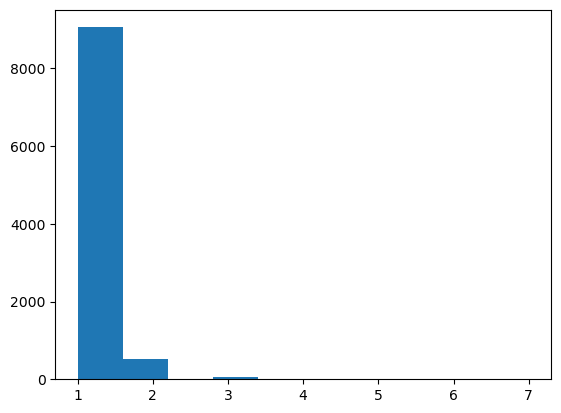

In [12]:
# first check consistency of NT within each type 
cb['top_nt'] = cb['top_nt'].fillna('unknown')
nt_count_per_type = cb.groupby('combined_type')['top_nt'].nunique()
plt.hist(nt_count_per_type)

In [13]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = cb[cb.combined_type.isin(nt_conflict_types)].groupby(['combined_type', 'top_nt']).size()

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name='counts')

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(by=['combined_type', 'counts'], ascending=[True, False], inplace=True)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(cb.combined_type, cb.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []

# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df['counts'].max()
    top_nts = df[df['counts'] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(df['combined_type'].iloc[0])  # Record the type with ties
        random_nt = np.random.choice(top_nts['top_nt'].values)
        while random_nt == 'unknown': 
            random_nt = np.random.choice(top_nts['top_nt'].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts['top_nt'].values[0]

# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts['combined_type'] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

232

In [14]:
# the types without any known nt 
[atype for atype, nt in type_nt.items() if nt == 'unknown']

['720575940638707901',
 'DNge061',
 '720575940612376690',
 'ITP',
 '720575940626896145',
 '720575940622611917',
 '720575940624156391',
 '720575940632738259',
 '720575940621636988',
 '720575940610239608',
 '720575940623382711',
 '720575940612269283',
 'AN_GNG_204',
 'AN_GNG_124',
 '720575940614957115',
 '720575940626216720',
 '720575940621463699',
 '720575940606375772',
 '720575940610183154',
 '720575940617816661',
 '720575940635901274',
 '720575940612137895',
 '720575940621568490',
 '720575940619617919',
 '720575940628335611',
 '720575940633705560',
 '720575940637470627',
 '720575940639152117',
 '720575940638909429',
 '720575940614736699',
 '720575940611937967',
 '720575940613684274',
 '720575940625771780',
 '720575940619904380',
 '720575940630846125',
 '720575940624211202',
 '720575940611477229',
 '720575940628628055',
 '720575940618759078',
 '720575940629273130',
 '720575940618109460',
 '720575940611810001',
 '720575940628268226',
 '720575940620287820',
 '720575940623758669',
 '72057

In [15]:
# update the top_nt column to be consistent within each type
cb.loc[:, ['top_nt']] = cb.combined_type.map(type_nt)
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type,known_nt_simplified
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN,PS180,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN,CB0924,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN,AVLP429,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN,AVLP151,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123502,79587599823629322,720575940618417409,130350,14001,3229,NaN,NaN,NaN,NaN,afferent,...,NaN,NaN,NaN,left,OCN,fw123599,FBbt_00004242,NaN,ocellar retinula cell,NaN
123503,79587599823608864,720575940628941553,130046,14747,3205,NaN,NaN,NaN,NaN,afferent,...,0.734219,NaN,NaN,left,OCN,fw123600,FBbt_00004242,NaN,ocellar retinula cell,NaN
123504,79728680842360672,720575940612567258,132026,19096,3069,NaN,NaN,NaN,NaN,afferent,...,0.729409,NaN,NaN,center,OCN,fw123601,FBbt_00004242,NaN,ocellar retinula cell,NaN
123505,79798912214529467,720575940630757750,133378,17839,3166,NaN,NaN,NaN,NaN,afferent,...,0.544816,NaN,NaN,center,OCN,fw123602,FBbt_00004242,NaN,ocellar retinula cell,NaN


In [16]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary 
nt_value = {'acetylcholine': 1, 
           'glutamate': -1, 
           'gaba': -1, 
           'dopamine': 1, 
           'serotonin': 1, 
           'octopamine': 1, 
           'unknown': 1}

# make coo

In [17]:
conn = conn[(conn.pre_pt_root_id.isin(cb.root_id)) & (conn.post_pt_root_id.isin(cb.root_id))]
# sym synapse numbers across neuropils 
conn = conn.groupby(['pre_pt_root_id', 'post_pt_root_id']).syn_count.sum().reset_index()
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940600433181,720575940605214636,10
1,720575940600433181,720575940605353649,3
2,720575940600433181,720575940606938313,1
3,720575940600433181,720575940609527069,1
4,720575940600433181,720575940612058543,3
...,...,...,...
6635821,720575940661338497,720575940635596212,2
6635822,720575940661338497,720575940639769715,1
6635823,720575940661338497,720575940643867296,1
6635824,720575940661338497,720575940645527918,1


In [18]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(cb.root_id)
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node:num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn['pre_idx'] = conn.pre_pt_root_id.map(nodes_to_idx) 
conn['post_idx'] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn['pre_idx'].values
col = conn['post_idx'].values
data = conn['syn_count'].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size/1e6

79.83232

In [19]:
csc.shape

(50601, 50601)

In [20]:
csc

<50601x50601 sparse matrix of type '<class 'numpy.int64'>'
	with 6635826 stored elements in Compressed Sparse Column format>

In [21]:
col_sums = csc.sum(axis=0)
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
# .A turns it from a sparse matrix into a dense np array
col_sums_with_inversion = np.reciprocal(col_sums.A.squeeze().astype(float), where=col_sums.A.squeeze() != 0)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

In [22]:
sp.sparse.save_npz('data/adult_inprop_cb_neuron.npz', inprop)

In [23]:
# save to csv, one row is one neuron 
meta = cb[['root_id', 'combined_type', 'side', 'top_nt', 'super_class',
           'cell_class', 'cell_sub_class', 'ito_lee_hemilineage', 'hartenstein_hemilineage']]
meta.loc[:,['idx']] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ['sign']] = meta.top_nt.map(nt_value)
meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)

# adult, right hemisphere, neuron level, meta information 
meta.to_csv('data/adult_cb_neuron_meta.csv')

C:\Users\44745\AppData\Local\Temp\ipykernel_118120\1088024298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)


In [24]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,ito_lee_hemilineage,hartenstein_hemilineage,idx,sign
0,720575940628857210,PS180,left,acetylcholine,central,NaN,NaN,SMPpv2_ventral,CP1_ventral,33601,1
1,720575940626838909,CB0924,right,acetylcholine,central,NaN,NaN,VLPl2_medial,BLAv2_medial,29427,1
2,720575940626046919,AVLP429,right,acetylcholine,central,NaN,NaN,NaN,NaN,27805,1
3,720575940630311383,AVLP151,right,acetylcholine,central,NaN,NaN,putative_primary,putative_primary,36434,1
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,NaN,NaN,41325,1
...,...,...,...,...,...,...,...,...,...,...,...
123502,720575940618417409,ocellar retinula cell,left,serotonin,sensory,visual,ocellar,NaN,NaN,13370,1
123503,720575940628941553,ocellar retinula cell,left,serotonin,sensory,visual,ocellar,NaN,NaN,33792,1
123504,720575940612567258,ocellar retinula cell,center,serotonin,sensory,visual,ocellar,NaN,NaN,5939,1
123505,720575940630757750,ocellar retinula cell,center,serotonin,sensory,visual,ocellar,NaN,NaN,37288,1
